In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import gpxpy
import ggps
import haversine

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [197]:
from gps_analysis import sphere, files, splits, garmin

In [12]:
positions = files.load_gpx("activity_768041870.gpx")
locations = pd.read_json('cam_locations.json', orient='index')
positions

,latitude,longitude,time,timeElapsed,distanceDelta,distance,bearing_r,bearing
0,52.211003,0.130434,2015-05-07 17:17:16+00:00,0 days 00:00:00,0.000000,0.000000,-2.947566,-168.883087
1,52.211131,0.130475,2015-05-07 17:18:48+00:00,0 days 00:01:32,0.014514,0.014514,-2.947566,-168.883087
2,52.211091,0.130508,2015-05-07 17:19:05+00:00,0 days 00:01:49,0.005001,0.019515,-0.475673,-27.254082
3,52.211024,0.130640,2015-05-07 17:19:12+00:00,0 days 00:01:56,0.011685,0.031200,-0.877730,-50.290213
4,52.210954,0.130768,2015-05-07 17:19:17+00:00,0 days 00:02:01,0.011636,0.042836,-0.845724,-48.456416
...,...,...,...,...,...,...,...,...
563,52.210635,0.131943,2015-05-07 18:21:05+00:00,0 days 01:03:49,0.020048,9.365145,1.865600,106.891014
564,52.210705,0.131614,2015-05-07 18:21:11+00:00,0 days 01:03:55,0.023716,9.388861,1.902649,109.013765
565,52.210758,0.131396,2015-05-07 18:21:15+00:00,0 days 01:03:59,0.016004,9.404865,1.952104,111.847345
566,52.210850,0.131081,2015-05-07 18:21:21+00:00,0 days 01:04:05,0.023780,9.428645,2.016539,115.539184


In [196]:
splits.find_all_best_times(positions).applymap(splits.strfmtsplit)

time     split
length distance                    
250m   2.683     00:57.88  01:55.76
       4.205     00:57.97  01:55.94
       2.356     00:58.75  01:57.50
       3.031     00:58.92  01:57.85
       3.678     00:59.24  01:58.49
       1.993     00:59.30  01:58.61
       4.459     00:59.44  01:58.88
       6.439     01:00.71  02:01.43
       8.166     01:01.68  02:03.36
       1.611     01:01.82  02:03.64
       7.673     01:01.96  02:03.92
       7.190     01:02.62  02:05.24
       6.706     01:03.15  02:06.31
       8.800     01:03.39  02:06.78
       9.194     01:03.90  02:07.80
       5.908     01:04.48  02:08.96
       4.987     01:04.55  02:09.10
       1.269     01:07.50  02:15.01
       8.483     01:08.21  02:16.43
       6.181     01:09.04  02:18.08
       3.361     01:09.18  02:18.37
       0.877     01:10.86  02:21.72
       5.509     01:12.56  02:25.12
       3.947     01:13.19  02:26.39
       0.615     01:13.41  02:26.83
       5.257     01:15.64  02:31.28
       0.365     01:19.82  02:39.65
       0.110     01:38.48  03:16.96
       4.712     14:50.21  29:40.43
500m   2.615     01:56.54  01:56.54
       4.163     01:57.38  01:57.38
       2.009     01:59.03  01:59.03
       6.237     02:02.63  02:02.63
       7.906     02:04.19  02:04.19
       6.986     02:08.52  02:08.52
       8.933     02:09.05  02:09.05
       1.369     02:10.10  02:10.10
       3.467     02:10.47  02:10.47
       5.002     02:20.31  02:20.31
       0.857     02:20.51  02:20.51
       8.422     02:21.19  02:21.19
       0.346     02:33.85  02:33.85
       5.650     02:35.34  02:35.34
1km    2.314     03:55.06  01:57.53
       3.699     04:09.90  02:04.95
       6.257     04:11.60  02:05.80
       7.673     04:17.74  02:08.87
       0.877     04:30.29  02:15.14
       5.157     05:03.17  02:31.58
1.5km  1.953     06:04.02  02:01.34
       5.984     06:26.97  02:08.99
       7.649     06:32.31  02:10.77
       0.365     07:03.78  02:21.26
       3.699     20:06.28  06:42.09
2km    1.953     08:14.55  02:03.63
       5.489     09:10.28  02:17.57
3km    1.953     08:14.55  02:03.63
       5.489     09:10.28  02:17.57
5km    1.953     08:14.55  02:03.63
       5.489     09:10.28  02:17.57

In [194]:
splits.find_best_times(positions, 0.5).applymap(splits.strfmtsplit)

,time,split
distance,,
2.615,01:56.54,01:56.54
4.163,01:57.38,01:57.38
2.009,01:59.03,01:59.03
6.237,02:02.63,02:02.63
7.906,02:04.19,02:04.19
6.986,02:08.52,02:08.52
8.933,02:09.05,02:09.05
1.369,02:10.10,02:10.10
3.467,02:10.47,02:10.47


In [102]:
loc_timings = splits.get_location_timings(positions, locations)
loc_timings.applymap(splits.strfmtsplit)

location                 top_finish peters_post morleys_holt path_split  \
distance                      1.656       1.892        2.062      2.130   
location        distance                                                  
top_finish      1.656      00:00.00    00:31.72     01:57.89   02:05.88   
peters_post     1.892      02:14.44    00:00.00     01:26.16   01:34.15   
morleys_holt    2.062      04:50.36    08:26.83     00:00.00   00:07.99   
path_split      2.130      04:25.58    06:35.62     01:57.59   00:00.00   
fivepost        2.336      03:41.81    04:28.25     02:00.23   02:01.10   
railway         2.342      03:40.81    04:26.11     01:59.95   02:00.71   
railings        2.771      03:00.99    03:13.49     01:58.36   01:58.44   
upstream_post   2.838      02:57.22    03:07.89     01:58.02   01:58.06   
exit_ditton     3.006      02:49.74    02:57.22     01:57.87   01:57.89   
entry_ditton    3.266      02:41.41    02:46.04     01:57.93   01:57.95   
plough          3.283      02:40.93    02:45.43     01:57.89   01:57.91   
exit_grassy     3.486      02:39.14    02:42.80     02:01.73   02:01.94   
entry_grassy    3.630      02:37.12    02:40.20     02:02.62   02:02.84   
exit_firstpost  3.792      02:35.64    02:38.28     02:04.03   02:04.29   
entry_firstpost 3.966      02:33.16    02:35.30     02:03.91   02:04.14   
headstation     4.089      02:33.32    02:35.35     02:05.87   02:06.16   
outflow         4.343      02:30.54    02:32.09     02:05.65   02:05.90   
                5.225      04:20.13    04:29.03     04:16.25   04:19.29   
headstation     5.455      04:13.56    04:21.45     04:09.16   04:11.85   
entry_firstpost 5.568      04:10.09    04:17.52     04:05.43   04:07.96   
exit_firstpost  5.763      04:05.33    04:12.09     04:00.39   04:02.69   
entry_grassy    5.910      04:04.33    04:10.79     03:59.48   04:01.67   
exit_grassy     6.023      04:01.40    04:07.51     03:56.39   03:58.46   
plough          6.239      03:56.93    04:02.50     03:51.74   03:53.63   
entry_ditton    6.284      03:55.83    04:01.28     03:50.59   03:52.44   
exit_ditton     6.526      03:50.27    03:55.15     03:44.80   03:46.46   
upstream_post   6.667      03:47.16    03:51.74     03:41.59   03:43.15   
railings        6.731      03:45.86    03:50.32     03:40.25   03:41.77   
fivepost        7.168      03:38.16    03:41.90     03:32.42   03:33.69   
railway         7.187      03:37.90    03:41.62     03:32.16   03:33.44   
path_split      7.392      03:34.58    03:38.02     03:28.81   03:29.99   
morleys_holt    7.475      03:33.34    03:36.68     03:27.57   03:28.71   
peters_post     7.604      03:32.89    03:36.13     03:27.21   03:28.32   
top_finish      7.867      03:44.00    03:47.53     03:39.35   03:40.56   

location                  fivepost   railway  railings upstream_post  \
distance                     2.336     2.342     2.771         2.838   
location        distance                                               
top_finish      1.656     02:30.83  02:31.47  03:21.81      03:29.47   
peters_post     1.892     01:59.10  01:59.74  02:50.08      02:57.75   
morleys_holt    2.062     00:32.94  00:33.58  01:23.92      01:31.58   
path_split      2.130     00:24.94  00:25.59  01:15.92      01:23.59   
fivepost        2.336     00:00.00  00:00.64  00:50.97      00:58.64   
railway         2.342     01:47.25  00:00.00  00:50.33      00:58.00   
railings        2.771     01:57.19  01:57.33  00:00.00      00:07.66   
upstream_post   2.838     01:56.82  01:56.93  01:54.43      00:00.00   
exit_ditton     3.006     01:56.90  01:56.99  01:56.37      01:57.15   
entry_ditton    3.266     01:57.25  01:57.31  01:57.30      01:57.75   
plough          3.283     01:57.22  01:57.28  01:57.24      01:57.66   
exit_grassy     3.486     02:02.09  02:02.16  02:05.07      02:06.17   
entry_grassy    3.630     02:03.12  02:03.20  02:06.13      02:07.12   
exit_firstpost  3.792     02:04.74  02:04.82  02:07.96      02:08.91   


In [358]:
i, j = np.triu_indices(len(positions), 1)
i, j

time_diffs = (
    positions.timeElapsed[j].dt.total_seconds().values - 
    positions.timeElapsed[i].dt.total_seconds().values)
time_diffs
dist_diffs =(
    positions.distance[j].values - 
    positions.distance[i].values)
time_diffs
speeds = 1000 * np.nan_to_num(dist_diffs / time_diffs)

In [364]:
best_times.groupby('length').split.min()

length
1.5km   0 days 00:01:54.792346254
1km     0 days 00:01:53.472220764
250m    0 days 00:01:50.047171826
2km     0 days 00:01:54.833386274
3km     0 days 00:02:05.042755199
500m    0 days 00:01:52.086820044
5km     0 days 00:02:13.426955227
Name: split, dtype: timedelta64[ns]

In [7]:
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient

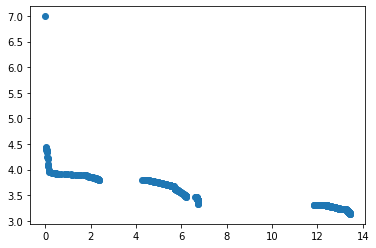

In [360]:
mask = is_pareto_efficient(np.c_[-dist_diffs, -speeds])

plt.scatter(
    dist_diffs[mask],
    speeds[mask]
)

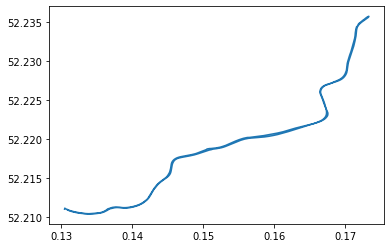

In [9]:
plt.plot(positions.longitude, positions.latitude)

In [242]:
api = garmin.login("imogen@gtsoftware.co.uk")

Input your Garmin password: ········


In [357]:
activities = garmin.get_activities(activityType='rowing', api=api)
activity_data, errors = garmin.load_activities(activities.activityId, api=api)
garmin.activity_data_to_excel(activities, activity_data, api=api)

  0%|          | 0/20 [00:00<?, ?it/s]

In [347]:
activities = garmin.get_activities(activityType='rowing', api=api)
activity_data, errors = garmin.load_activities(activities.activityId, api=api)

  0%|          | 0/20 [00:00<?, ?it/s]

In [363]:
activity_td = activities[
    ['activityId', 'startTimeLocal', 'distance']
].sort_values(by='startTimeLocal', ascending=False)
activity_td.columns = ['activityId', 'startTime', 'totalDistance']

activity_td.totalDistance = (activity_td.totalDistance/1000).round(1)

activity_best_times = pd.concat({
    actid: splits.find_all_best_times(activity_data[actid])
    for actid in activity_td.activityId
}, 
    names = ('activityId', 'length', 'distance')
)

best_times = activity_best_times.reset_index().join(
    activity_td.set_index('activityId'), on='activityId').set_index(
    ['activityId', 'startTime', 'totalDistance', 'length', 'distance']
)
best_times

time  \
activityId startTime           totalDistance length distance                             
8042902687 2022-01-01 12:08:50 14.0          250m   3.844    0 days 00:01:07.873069383   
                                                    4.253    0 days 00:01:08.355684529   
                                                    3.529    0 days 00:01:08.518017441   
                                                    3.164    0 days 00:01:08.894069778   
                                                    8.300    0 days 00:01:09.566044946   
...                                                                                ...   
7908679153 2021-12-03 13:32:39 13.4          3km    9.747    0 days 00:14:21.120834510   
                                                    6.731    0 days 00:14:29.564518928   
                                                    0.163    0 days 00:16:10.797074144   
                                             5km    1.602    0 days 00:22:14.269552272   
                                                    6.731    0 days 00:24:08.463738564   

                                                                                 split  
activityId startTime           totalDistance length distance                            
8042902687 2022-01-01 12:08:50 14.0          250m   3.844    0 days 00:02:15.746138766  
                                                    4.253    0 days 00:02:16.711369058  
                                                    3.529    0 days 00:02:17.036034882  
                                                    3.164    0 days 00:02:17.788139556  
                                                    8.300    0 days 00:02:19.132089892  
...                                                                                ...  
7908679153 2021-12-03 13:32:39 13.4          3km    9.747    0 days 00:02:23.520139085  
                                                    6.731    0 days 00:02:24.927419821  
                                                    0.163    0 days 00:02:41.799512357  
                                             5km    1.602    0 days 00:02:13.426955227  
                                                    6.731    0 days 00:02:24.846373856  

[1531 rows x 2 columns]

In [351]:
with pd.ExcelWriter("imogen_data.xlsx") as xlf:
    activities.to_excel(xlf, "activities")
    best_times.applymap(splits.strfmtsplit).to_excel(xlf, "best_times")

In [306]:
best_times

time                     split
length distance                                                    
250m   5.305    0 days 00:01:03.488658398 0 days 00:02:06.977316796
       5.910    0 days 00:01:03.830482381 0 days 00:02:07.660964762
       5.557    0 days 00:01:03.994571691 0 days 00:02:07.989143382
       3.263    0 days 00:01:04.000436548 0 days 00:02:08.000873096
       4.816    0 days 00:01:04.014676891 0 days 00:02:08.029353782
...                                   ...                       ...
5km    4.621    0 days 00:08:40.841627787 0 days 00:02:10.210406946
       6.755    0 days 00:09:21.107731826 0 days 00:02:20.276932956
       11.359   0 days 00:09:27.916965314 0 days 00:02:21.979241328
       9.247    0 days 00:09:30.265924278 0 days 00:02:22.566481069
       0.274    0 days 00:11:37.083518549 0 days 00:02:54.270879637

[95 rows x 2 columns]

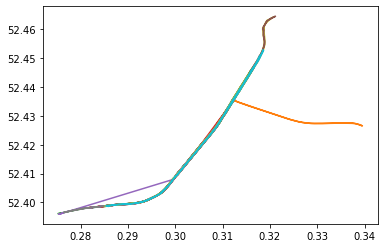

In [299]:
for positions in activity_data.values():
    plt.plot(positions.longitude, positions.latitude)

In [ ]:
api.download_activity(activity_id, dl_fmt=api.ActivityDownloadFormat.GPX)

In [235]:
pd.DataFrame.from_records(activities).activityType.map(lambda x: x['typeKey'])

0           running
1    indoor_cycling
2        stop_watch
3    indoor_cycling
4    indoor_cycling
5    indoor_cycling
6    indoor_cycling
7           running
8           running
9            rowing
Name: activityType, dtype: object

In [204]:
for activity in activities:
    activity_id = activity["activityId"]
    print("api.download_activities(%s)" % activity_id)

    gpx_data = api.download_activity(activity_id, dl_fmt=api.ActivityDownloadFormat.GPX)
    output_file = f"./{str(activity_id)}.gpx"
    with open(output_file, "wb") as fb:
        fb.write(gpx_data)

api.download_activities(8038445408)
api.download_activities(8027849509)
api.download_activities(8026731194)
api.download_activities(8018505422)
api.download_activities(8004776665)
api.download_activities(7996011972)
api.download_activities(7987180716)
api.download_activities(7965033242)
api.download_activities(7936819819)
api.download_activities(7909026583)


In [226]:
activities[0]

{'activityId': 8038445408,
 'activityName': 'South Cambridgeshire Running',
 'description': None,
 'startTimeLocal': '2021-12-31 13:19:01',
 'startTimeGMT': '2021-12-31 13:19:01',
 'activityType': {'typeId': 1,
  'typeKey': 'running',
  'parentTypeId': 17,
  'isHidden': False,
  'restricted': False,
  'trimmable': True,
  'sortOrder': None},
 'eventType': {'typeId': 9, 'typeKey': 'uncategorized', 'sortOrder': 10},
 'comments': None,
 'parentId': None,
 'distance': 10679.919921875,
 'duration': 3070.701904296875,
 'elapsedDuration': 3070.701904296875,
 'movingDuration': 2975.9309844970703,
 'elevationGain': 30.0,
 'elevationLoss': 16.0,
 'averageSpeed': 3.4779999256134033,
 'maxSpeed': 4.35699987411499,
 'startLatitude': 52.189595801755786,
 'startLongitude': 0.12455005198717117,
 'hasPolyline': True,
 'ownerId': 3467998,
 'ownerDisplayName': 'matthewghgriffiths',
 'ownerFullName': 'Matthew Griffiths',
 'ownerProfileImageUrlSmall': 'https://s3.amazonaws.com/garmin-connect-prod/profile_i

In [216]:
downloads, errors = garmin.download_activities(activities)

  0%|          | 0/10 [00:00<?, ?it/s]

In [225]:
api.get_activities?